This notebook explores whether rapid rehousing is essentially a signal for getting into permanent housing.

autor: annalie

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
%load_ext autoreload
# # the "1" means: always reload modules marked with "%aimport"
%autoreload 2

from __future__ import absolute_import, division, print_function
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os, sys
# from tqdm import tqdm
# import warnings

# sns.set_context("poster", font_scale=0.9)
sns.set_context("notebook", font_scale=1.0)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 1000)

# add the data functions to the path
annalie = 'data/c4sf/C4SF-datasci-homeless/raw/'
datadir = os.path.join(os.getenv('HOME'), annalie)

src_data_dir = os.path.join(os.getcwd(), os.pardir, 'src/data')
sys.path.append(src_data_dir)

# functions to load the data
import dataset_homeless as ds

In [2]:
# load in and process the data in separate sheets

df_client = ds.process_data_client(simplify_strings=True, datadir=datadir)

df_enroll = ds.process_data_enrollment(simplify_strings=True, datadir=datadir)

# Only keep rows with entry dates starting in 2012
df_enroll = df_enroll[df_enroll['Entry Date'] >= '2012']
# Only keep rows with exit dates before 2016-06-01
df_enroll = df_enroll[df_enroll['Exit Date'] <= '2016-06-01']

df_disability = ds.process_data_disability(simplify_strings=True, datadir=datadir)

df_healthins = ds.process_data_healthins(simplify_strings=True, datadir=datadir)

df_benefit = ds.process_data_benefit(simplify_strings=True, datadir=datadir)

df_income = ds.process_data_income(simplify_strings=True, datadir=datadir)

df_project = ds.process_data_project(simplify_strings=True, datadir=datadir)

df_service = ds.process_data_service(simplify_strings=True, datadir=datadir)

df_bedinv = ds.process_data_bedinventory(simplify_strings=True, datadir=datadir)

# Join the client information with enrollment information.
# Inner join because we want to only keep individuals
# for whom we have both client and enrollment information.
df = df_client.merge(df_enroll, how='inner', left_index=True, right_index=True)

# just choose the first non-cash benefit; this is too simple!
# TODO: join on the exact Project ID, and possible Date
df = df.merge(df_benefit.reset_index().groupby(by=['Personal ID'])[['Non-Cash Benefit']].nth(0),
              how='left', left_index=True, right_index=True)
# # possible fix for above, but this isn't working properly (results in too many rows);
# # probably need date too, but they do not align
# df.reset_index().merge(df_benefit.reset_index()[['Personal ID', 'Project Entry ID', 'Non-Cash Benefit']].drop_duplicates(),
#                        how='left',
#                        on=['Personal ID', 'Project Entry ID'],
#                       ).drop_duplicates().set_index('Personal ID')

df['Non-Cash Benefit'] = df['Non-Cash Benefit'].fillna('None')

# add information about their disability status
# just choose the first disability; this is too simple!
# TODO: join on the exact Project ID
df = df.merge(df_disability.reset_index().groupby(by=['Personal ID'])[['Disability Type']].nth(0),
              how='left', left_index=True, right_index=True)
# # possible fix for above, but this isn't working properly (results in too many rows);
# # probably need date too, but they do not align
# df.reset_index().merge(df_disability.reset_index()[['Personal ID', 'Project Entry ID', 'Disability Type']].drop_duplicates(),
#                        how='left',
#                        on=['Personal ID', 'Project Entry ID'],
#                       ).drop_duplicates().set_index('Personal ID')

df['Disability Type'] = df['Disability Type'].fillna('None')

# add Project Type Code to DataFrame
df = df.merge(df_project[['Project Name',
                          'Project Type Code',
                          'Address City',
                          'Address Postal Code',
                         ]], left_on=['Project ID'], right_index=True)

# sort by entry date
df = df.sort_values('Entry Date')

# rename the columns to have no spaces
df = ds.rename_columns(df)

In [3]:
df_resetidx = df.reset_index()

df.shape
len(df_resetidx['Personal ID'].unique())

11362

    Number of records (ids) in df: 58209
    Number of unique ids in df: 11362

### Number of times in permanent housing

In [4]:
# create new column with a numeric value for the variable 'In Permanent Housing'
df_enroll['category In Permanent Housing'] = df_enroll['In Permanent Housing'].apply(lambda x: 1 if x==True else 0)

# create a dataframe of only the variables that are to be grouped
# select only the people that have been in permanent housing before
# group dataframe by Personal ID and sum the times that this person was in permanent housing
# rename the column with the sum of the grouped rows to the number of times this person had been in permanent housing
df_housing = df_enroll.reset_index()[['Personal ID', 'category In Permanent Housing']]

df_housing = df_housing[df_housing['category In Permanent Housing']==1] \
                        .groupby(by=['Personal ID']) \
                        .sum() \
                        .rename(columns={'category In Permanent Housing': 'times_in_permanent_housing'})

# merge the dataframe that contains the number of times enrolled with the large dataframe
df = df.merge(df_housing, how='left', left_index=True, right_index=True)
# replace the missing values in the column times_enrolled with 0 
df['times_in_permanent_housing'].fillna(0, inplace=True)

df.head()

,race,ethnicity,gender,veteran_status,project_entry_id,client_age_at_entry,last_permanent_zip,entry_date,exit_date,project_id,housing_status_project_start,living_situation_before_program_entry,client_location,household_id,disabling_condition,continuously_homeless_one_year,times_homeless_past_three_years,months_homeless_this_time,chronic_homeless,in_permanent_housing,residential_move_in_date,domestic_violence_victim,months_ago_dv_occurred,dv_currently_fleeing,days_enrolled,days_to_residential_move_in,head_of_household,noncash_benefit,disability_type,project_name,project_type_code,address_city,address_postal_code,times_in_permanent_housing
Personal ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
173781,white,latino,female,False,252608,34,93907,2014-02-28,2014-02-28,2104,atrisk,rental,NaN,252608,False,False,NaN,NaN,False,False,NaT,True,24,False,0,NaN,False,foodstamps,None,MOSBE SOP - Mobile Outreach Shelter Program - ...,streetoutreach,NaN,93933,0.0
173781,white,latino,female,False,314080,35,93907,2014-05-06,2014-09-30,2101,cat1homeless,emershelter,CA-506,314080,False,False,2,NaN,False,False,NaT,True,12,False,147,NaN,False,foodstamps,None,MOSBE SOP - Natividad Shelter,emergencyshelter,Marina,93933,0.0
173782,white,latino,male,False,314084,10,93905,2014-05-06,2014-09-30,2101,cat1homeless,emershelter,CA-506,314080,False,True,2,NaN,False,False,NaT,True,12,False,147,NaN,False,None,None,MOSBE SOP - Natividad Shelter,emergencyshelter,Marina,93933,0.0
173783,white,latino,female,False,314085,12,93905,2014-05-06,2014-09-30,2101,cat1homeless,emershelter,CA-506,314080,False,True,2,NaN,False,False,NaT,True,12,False,147,NaN,False,None,None,MOSBE SOP - Natividad Shelter,emergencyshelter,Marina,93933,0.0
173803,white,latino,female,False,201286,32,93905,2013-02-08,2013-04-27,2101,cat1homeless,friend,NaN,201286,False,False,NaN,NaN,False,False,NaT,True,12,False,78,NaN,False,foodstamps,None,MOSBE SOP - Natividad Shelter,emergencyshelter,Marina,93933,0.0


In [5]:
# number of records in the dataset
df.shape

(58209, 34)

### Determine whether rapid rehousing is essentially a signal for getting into permanent housing
- show the distribution of the people that received rapid rehousing and received permanent housing versus the people that did not receive permanent housing

In [7]:
# address postal code for the same organization (project name) is not consistent, therefore, remove this variable
# remove duplicated rows

df2 = df.drop('address_postal_code', axis=1)
df2 = df2.drop_duplicates()
df2.shape

(54400, 33)

In [8]:
df2.project_type_code.unique()

array(['streetoutreach', 'emergencyshelter', 'other',
       'transitionalhousing', 'servicesonly', 'homelessnessprevention',
       'rapidrehousing', 'permanentsupportivehousing'], dtype=object)

In [9]:
# select only the cases where 'project_type_code' is 'rapidrehousing'
df_rapidrehousing = df2[(df2['project_type_code'] == 'rapidrehousing')]

# df_rapidrehousing = df_rapidrehousing[['project_type_code', 'in_permanent_housing']]

In [10]:
pd.value_counts(df_rapidrehousing['in_permanent_housing'].values, sort=False)

False    627
True     615
dtype: int64

### When address postal code is removed from the dataset, rapid rehousing leads in more cases not to permanent housing compared to receiving permanent housing

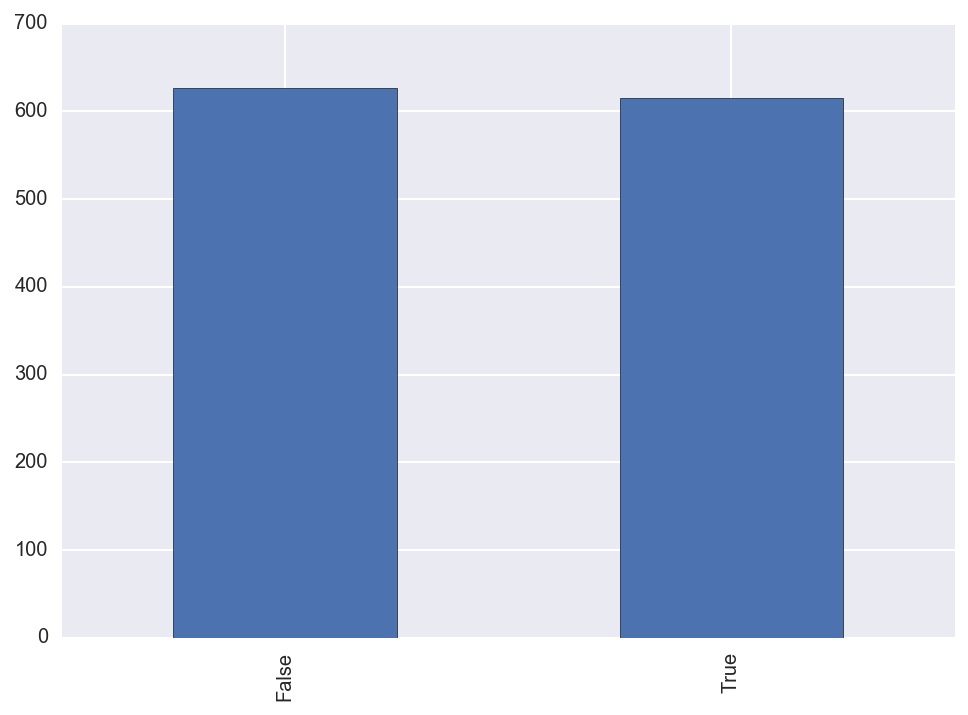

In [11]:
df_rapidrehousing['in_permanent_housing'].value_counts().plot(kind='bar')

Almost 50% of the people that received rapidrehousing got in permanent housing, whereas the other 50% didn't

### Determine how long people spend in rapid rehousing before they receive permanent housing
Assume that people that received permanent housing were for a shorter amount of time in rapid rehousing than 	people that did not receive permanent housing
1. Show a frequency distribution of the time that people spend in rapid rehousing and received permanent housing (*days to residential move in*)
2. Show a frequency distribution of the time that people spend in rapid rehousing and did not receive permanent 	housing (*days enrolled*)

In [14]:
# 1.
# create dataframe of people that were in rapid rehousing and received permanent housing 
# and where days to residential move in is not missing 
df_rapidrehousing_permanent_housing = df_rapidrehousing[(df_rapidrehousing['in_permanent_housing'] == True) & df_rapidrehousing['days_to_residential_move_in'].notnull()]
df_rapidrehousing_permanent_housing.head()

,race,ethnicity,gender,veteran_status,project_entry_id,client_age_at_entry,last_permanent_zip,entry_date,exit_date,project_id,housing_status_project_start,living_situation_before_program_entry,client_location,household_id,disabling_condition,continuously_homeless_one_year,times_homeless_past_three_years,months_homeless_this_time,chronic_homeless,in_permanent_housing,residential_move_in_date,domestic_violence_victim,months_ago_dv_occurred,dv_currently_fleeing,days_enrolled,days_to_residential_move_in,head_of_household,noncash_benefit,disability_type,project_name,project_type_code,address_city,times_in_permanent_housing
Personal ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
174275,white,nonlatino,male,True,469696,48,93905,2015-01-20,2015-06-01,3385,cat1homeless,streets,CA-506,469696,True,True,2,NaN,True,True,2015-02-01,False,NaN,False,132,12.0,True,None,chronichealth,MOSBE HRC - SSVF- P1 - HRC RRH,rapidrehousing,Salinas,2.0
174757,white,latino,male,True,432480,53,93901,2014-10-01,2015-09-04,3382,cat1homeless,streets,CA-506,432480,True,True,2,24,True,True,2015-08-19,False,NaN,False,338,322.0,True,foodstamps,mentalhealth,MOSBE HRC - SSVF- P2 HRC - RRH- Monterey/San B...,rapidrehousing,Salinas,2.0
174839,black,latino,male,True,443047,65,93940,2015-03-19,2016-04-21,3387,cat1homeless,transitionalhousing,CA-506,443047,True,False,2,24,False,True,2016-03-07,False,NaN,False,399,354.0,True,None,chronichealth,MOSBE HRC - SSVF- P1 - VTC RRH,rapidrehousing,Salinas,1.0
175160,black,nonlatino,male,True,471957,60,93901,2015-06-11,2015-09-29,3385,cat1homeless,streets,CA-508,471957,False,False,1,7,False,True,2015-06-16,False,NaN,False,110,5.0,True,foodstamps,physical,MOSBE HRC - SSVF- P1 - HRC RRH,rapidrehousing,Salinas,1.0
176042,white,nonlatino,male,True,445127,58,93901,2015-03-17,2015-06-23,3382,unknown,streets,CA-506,445127,True,False,1,0,False,True,2015-05-15,False,NaN,False,98,59.0,True,foodstamps,chronichealth,MOSBE HRC - SSVF- P2 HRC - RRH- Monterey/San B...,rapidrehousing,Salinas,1.0


In [17]:
df_rapidrehousing_permanent_housing_resetidx = df_rapidrehousing_permanent_housing.reset_index()

df_rapidrehousing_permanent_housing.shape
# len(df_rapidrehousing_permanent_housing_resetidx['Personal ID'].unique())

(532, 33)

Number of people that received rapid rehousing and permanent housing:

- 532 records
- 516 unique ids

In [18]:
# count number of records where times_in_permanent_housing > 1.0
len(df_rapidrehousing_permanent_housing[(df_rapidrehousing_permanent_housing['times_in_permanent_housing'] > 1.0)])

117

In [34]:
# max number of days to residential move in
df_rapidrehousing_permanent_housing['days_to_residential_move_in'].max()

443.0

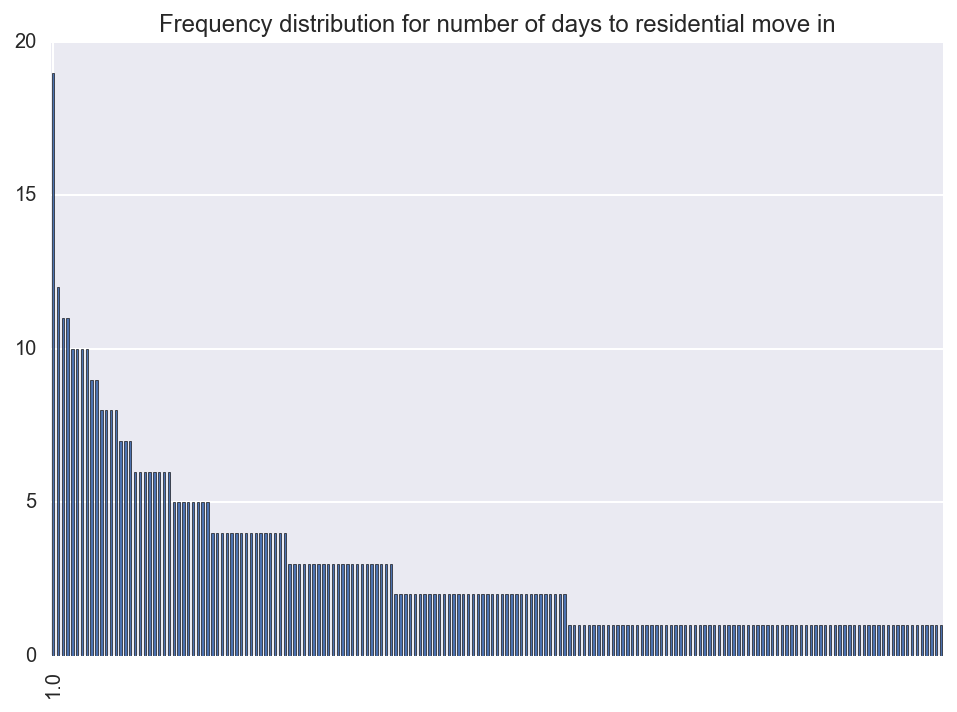

In [39]:
n = 443
ax = df_rapidrehousing_permanent_housing['days_to_residential_move_in'].value_counts().plot(kind='bar', title='Frequency distribution for number of days to residential move in')
ticks = ax.xaxis.get_ticklocs()
ax.xaxis.set_ticks(ticks[::n])

ax.figure.show()

In [43]:
# 2.
# create dataframe of people that were in rapid rehousing and did not receive permanent housing 
df_rapidrehousing_not_permanent_housing = df_rapidrehousing[(df_rapidrehousing['in_permanent_housing'] == False)]

In [44]:
df_rapidrehousing_not_permanent_housing.shape

(627, 33)

In [46]:
# max number of days enrolled
df_rapidrehousing_not_permanent_housing['days_enrolled'].max()

835

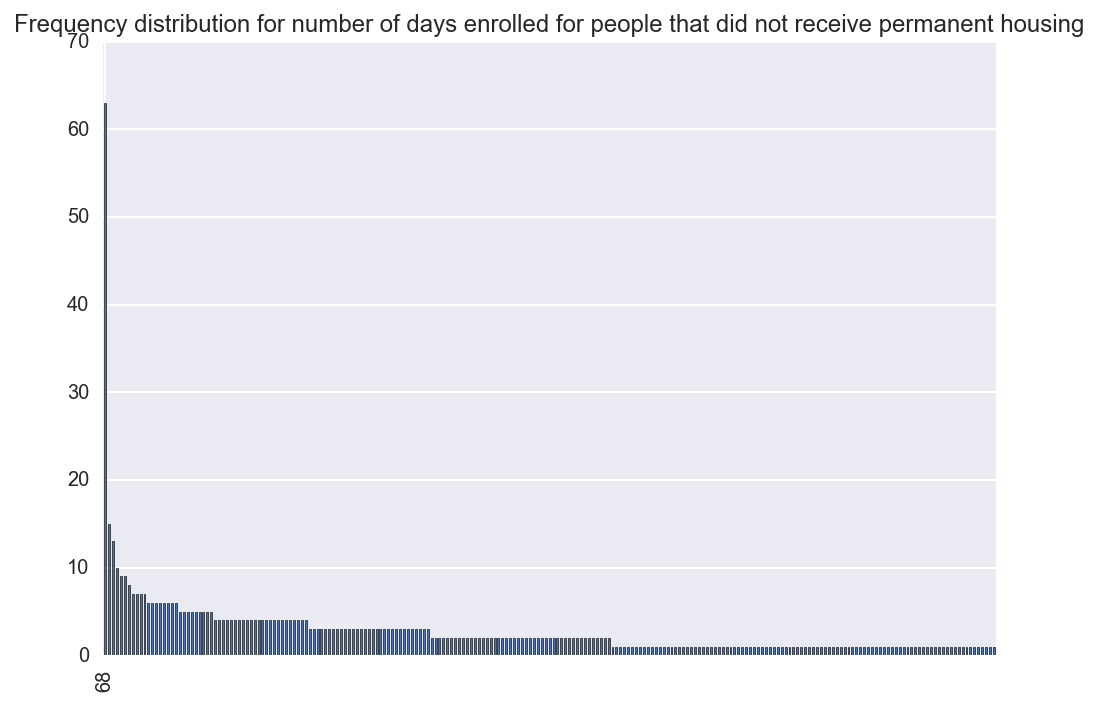

In [47]:
n = 835
ax = df_rapidrehousing_not_permanent_housing['days_enrolled'].value_counts().plot(kind='bar', title='Frequency distribution for number of days enrolled for people that did not receive permanent housing')
ticks = ax.xaxis.get_ticklocs()
ax.xaxis.set_ticks(ticks[::n])

ax.figure.show()

### Determine of those people that have received permanent housing before, whether rapid rehousing was effective
- show of the people that received permanent housing multiple times the % that received rapid rehousing as their first project

In [51]:
# show number of records that has received permanent housing multiple times 
len(df2)
len(df2[df2['times_in_permanent_housing'] > 1.0])

993

In [53]:
# create a dataframe that contains the people that received permanent housing before
df_perm_housing_before = df2[df2['times_in_permanent_housing'] > 1.0]

In [57]:
# keep the first record of each Personal ID 
# calculate the % of the people that were in rapid rehousing

# reset index
df_perm_housing_before_resetidx = df_perm_housing_before.reset_index()

# get the first row of each group
df_first_project = df_perm_housing_before_resetidx.groupby('Personal ID').first()

# count project type codes
pd.value_counts(df_first_project['project_type_code'].values, sort=False)

rapidrehousing                40
streetoutreach                 5
transitionalhousing            9
servicesonly                  23
homelessnessprevention        63
emergencyshelter              37
other                         26
permanentsupportivehousing     3
dtype: int64

In [58]:
df_first_project.shape

(206, 33)

In [59]:
# percentage of people that received rapid rehousing and later returned as homelessness
40/206*100

19.41747572815534